### 5. Resultados Preliminares

#### Análisis Preliminar de los Datos

Durante la etapa de exploración inicial se detectó que un gran número de juegos no cuenta con reviews registradas. Esto representa un problema, ya que la variable que buscamos predecir es precisamente el promedio de puntuaciones obtenidas a través de estas reviews.

Además, no todos los jugadores registran el abandono o cuando rejuegan algun juego. Esto implica que trabajar con juegos que tienen muy pocos registros totales pueden introducir ruido en el análisis. Por ejemplo, un juego podría parecer que tiene baja tasa de abandono simplemente porque nadie registró haberlo abandonado, o parecer rejugable por un único registro. En juegos con una base de jugadores muy reducida, estas interpretaciones pueden ser erróneas.

Debido a lo anterior, fue necesario establecer **umbrales mínimos (thresholds)** para considerar un juego en el análisis. Estos thresholds fueron definidos inicialmente desde un punto de vista exploratorio, basándose en la distribución de reseñas. Se probaron distintos valores para evaluar su impacto en la calidad de los datos.

![review-dist1](img/review-distribution1.png)

#### Construcción del Conjunto de Datos

Una vez definidos los thresholds, se creó un nuevo dataframe filtrado que solo contiene los juegos que superan dichos umbrales. Este nuevo conjunto de datos conserva únicamente las columnas relevantes: número de usuarios que completaron, abandonaron, rejugaron, reseñaron, el total de usuarios por juego, y el promedio de reviews.

A partir de estas columnas, se construyeron nuevas métricas:

- **Tasa de abandono**: usuarios que abandonaron dividido por el total de usuarios.
- **Tasa de rejugabilidad**: usuarios que rejugaron dividido por el total de usuarios.
- **Engagement**: una nueva métrica definida como la proporción entre los usuarios que completaron o rejugaron un juego respecto a la suma de estos y los que abandonaron.

Se observó que estas tasas entregaban mejores metricas en los modelos al calcularlas respecto del total de usuarios, en lugar de tomar como base únicamente los completados. Ademas, agregar la métrica de engagement mostró una mejora significativa en el valor de R², lo que sugiere que aporta valor predictivo.

#### Análisis de Correlaciones

Con el dataframe ya procesado, se definieron las variables:
- `X`: compuesto por las tres tasas mencionadas.
- `y`: correspondiente al promedio de reviews por juego.

Se realizaron visualizaciones para investigar patrones entre las tasas y la variable objetivo, así como una matriz de correlación. Estas herramientas confirmaron la existencia de correlaciones entre las tasas y el promedio de reviews, siendo **engagement** la más clara.

![scatter-rates](img/scatter-rates1.png)
![juegos_vs_juegos_con_review](img/correlation-matrix.png)

#### Entrenamiento y Evaluación de Modelos

El conjunto de datos fue dividido en entrenamiento y prueba, utilizando una proporción 80/20. Se entrenaron distintos modelos para predecir el promedio de reviews:

- **Regresión lineal**
- **Random Forest**
- Ambos modelos también fueron tambien evaluados utilizando **Polynomial Features**

| Modelo                     |     R²     |    MSE     |
|---------------------------|------------|------------|
| Linear Regression         |  0.426646  | 53.414461  |
| Polynomial Regression     |  0.483635  | 48.105336  |
| Random Forest             |  0.439527  | 52.214458  |
| Polynomial + Random Forest|  0.443171  | 51.874948  |

#### Conclusiones Preliminares

Los resultados indican que, si bien las tasas de abandono, rejugabilidad y engagement muestran cierta correlación con el promedio de reviews, **no es posible predecirlo con gran precisión utilizando estos modelos y características**. El mejor desempeño obtenido fue un R² de **0.45** y un error estándar mínimo de **48**, lo cual es considerable si se toma en cuenta que las puntuaciones están en una escala de 0 a 100.

#### Posibles Mejoras

Para futuros experimentos se proponen las siguientes mejoras:

- Ajustar de forma más precisa los thresholds, filtrando con base en la representatividad real de los registros.
- Explorar la incorporación de nuevas variables relacionadas al engagement u otras métricas del juego.
- Evaluar otros modelos de entrenamiento que puedan capturar relaciones no lineales o más complejas en los datos.

Estos ajustes permitirán refinar la capacidad predictiva del modelo y acercarse de mejor forma a la pregunta de investigación planteada.

In [283]:
import pandas as pd

# Cargar CSV
csv_path = './hltb_data.csv'
df = pd.read_csv(csv_path, low_memory=False)

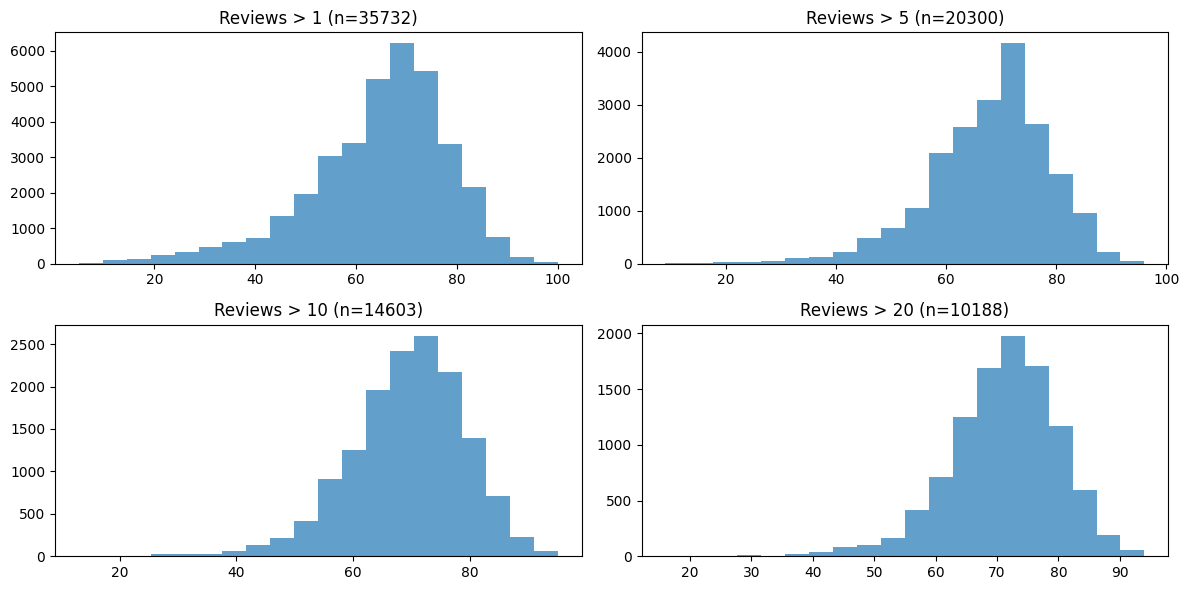

In [284]:
thresholds = [1, 5, 10, 20]
plt.figure(figsize=(12, 6))
for i, thresh in enumerate(thresholds):
    subset = df[df['game_count_review'] > thresh]['game_review_score']
    plt.subplot(2, 2, i+1)
    plt.hist(subset, bins=20, alpha=0.7)
    plt.title(f'Reviews > {thresh} (n={len(subset)})')
plt.tight_layout()
plt.show()

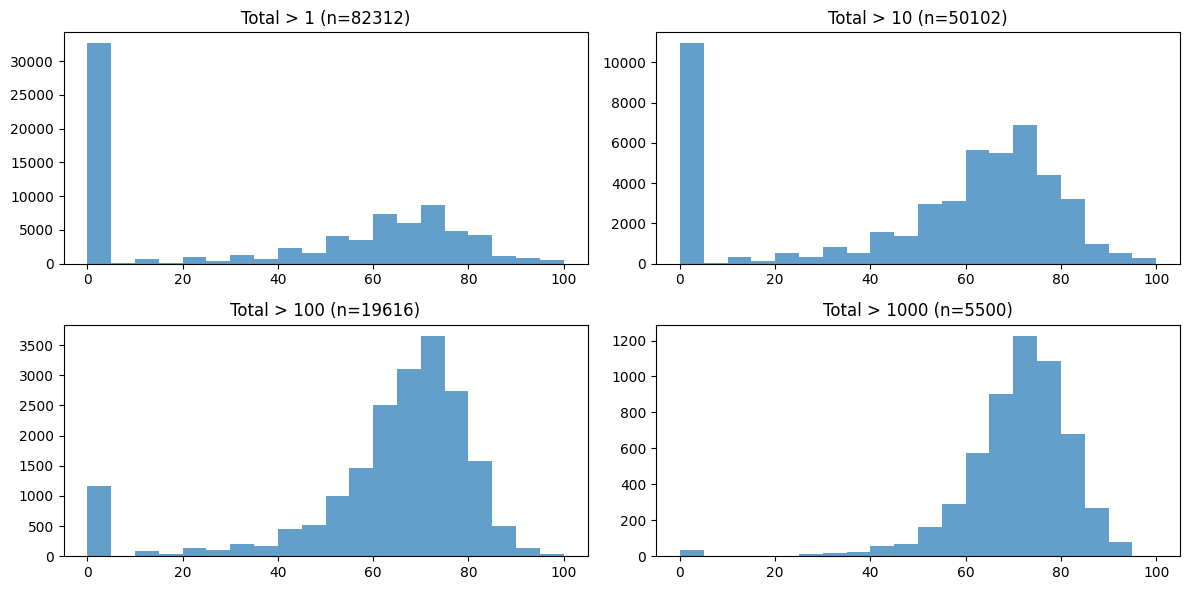

In [285]:
thresholds = [1, 10, 100, 1000]
plt.figure(figsize=(12, 6))
for i, thresh in enumerate(thresholds):
    subset = df[df['game_count_total'] > thresh]['game_review_score']
    plt.subplot(2, 2, i+1)
    plt.hist(subset, bins=20, alpha=0.7)
    plt.title(f'Total > {thresh} (n={len(subset)})')
plt.tight_layout()
plt.show()

In [286]:
df_completion = df[df['game_count_total'] >= 1000][df['game_count_review'] > 5][['game_count_comp', 'game_count_total', 'game_count_retired', 'game_count_replay', 'game_count_review', 'game_review_score']].copy()

df_completion.head()
df_completion.describe(include='all')

/tmp/ipykernel_81775/1070530764.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_completion = df[df['game_count_total'] >= 1000][df['game_count_review'] > 5][['game_count_comp', 'game_count_total', 'game_count_retired', 'game_count_replay', 'game_count_review', 'game_review_score']].copy()


,game_count_comp,game_count_total,game_count_retired,game_count_replay,game_count_review,game_review_score
count,5256.000000,5256.000000,5256.000000,5256.000000,5256.000000,5256.000000
mean,1149.481545,4419.319635,219.053463,45.202055,359.909437,71.464802
std,2253.666663,5322.630213,333.913105,109.655637,657.844411,9.561474
min,10.000000,1000.000000,3.000000,0.000000,6.000000,25.000000
25%,171.000000,1584.750000,56.000000,6.000000,44.000000,66.000000
50%,433.000000,2634.000000,107.000000,15.000000,133.000000,72.000000
75%,1067.000000,4826.250000,242.000000,38.000000,360.000000,78.000000
max,36371.000000,62909.000000,5227.000000,2165.000000,7552.000000,94.000000


In [287]:
# Calcular tasa de abandono (retired rate)
df_completion['retired_rate'] = df_completion['game_count_retired'] / df_completion['game_count_total']

# Calcular tasa de rejuego (replay rate)
df_completion['replay_rate'] = df_completion['game_count_replay'] / df_completion['game_count_total']

df_completion['engagement_score'] = (df['game_count_replay'] + df['game_count_comp']) / (    df['game_count_retired'] + df['game_count_comp'] + df['game_count_replay'])
# Variable objetivo
y = df_completion['game_review_score']

# Variables predictoras
X = df_completion[['retired_rate', 'replay_rate', 'engagement_score']]

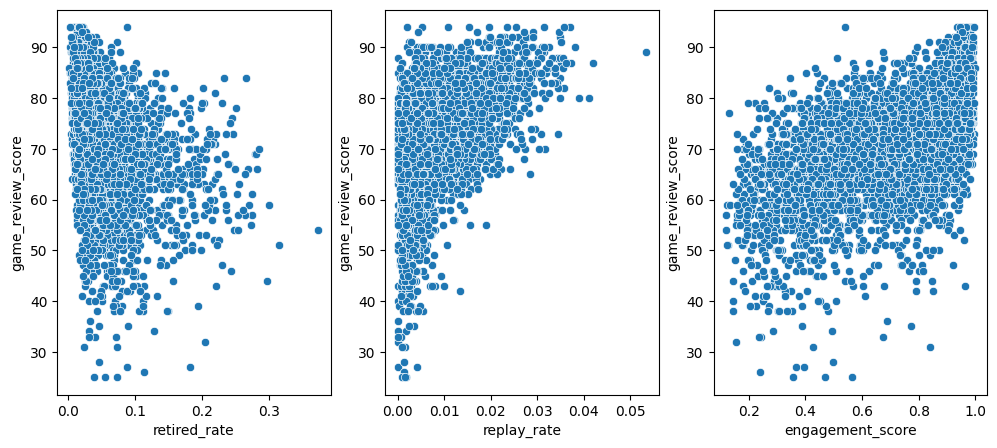

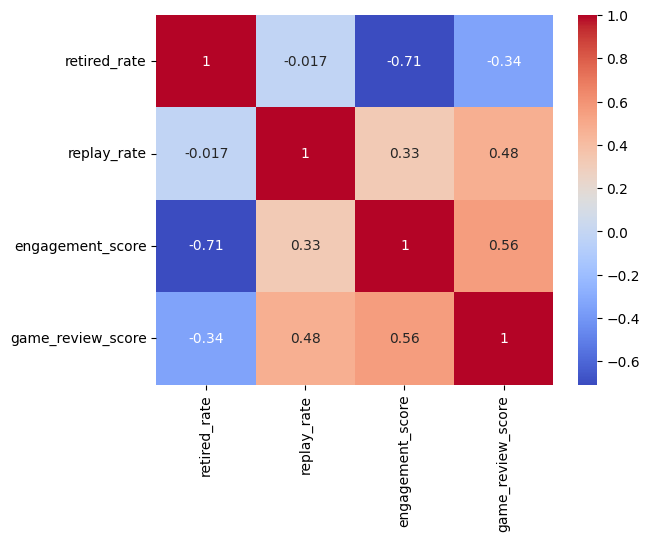

In [288]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
sns.scatterplot(x='retired_rate', y='game_review_score', data=df_completion, ax=ax1)
sns.scatterplot(x='replay_rate', y='game_review_score', data=df_completion, ax=ax2)
sns.scatterplot(x='engagement_score', y='game_review_score', data=df_completion, ax=ax3)
plt.show()

# Matriz de correlación
corr_matrix = df_completion[['retired_rate', 'replay_rate', 'engagement_score', 'game_review_score']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [289]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.8, random_state= 42)

In [290]:
model = LinearRegression()
model.fit(X_train, y_train)
predict = model.predict(X_test)
r2_reg = r2_score(y_test, predict)
mse_reg = mean_squared_error(y_test, predict)
print(r2_reg)
print(mse_reg)

0.42664621345776155
53.41446060502529


In [291]:
poly = PolynomialFeatures(3)
X2_train = poly.fit_transform(X_train)
X2_test = poly.fit_transform(X_test)

model = LinearRegression()
model.fit(X2_train, y_train)
predict2 = model.predict(X2_test)
r2_reg2 = r2_score(y_test, predict2)
mse_reg2 = mean_squared_error(y_test, predict2)
print(r2_reg2)
print(mse_reg2)

0.4836346485185349
48.10533630700085


In [292]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
r2_rf = r2_score(y_test, rf_pred)
mse_rf = mean_squared_error(y_test, rf_pred)
print(r2_rf)
print(mse_rf)

0.4395271061856131
52.21445817490494


In [297]:
poly2 = PolynomialFeatures(3)
X2_train2 = poly2.fit_transform(X_train)
X2_test2 = poly2.fit_transform(X_test)

rf2 = RandomForestRegressor()
rf2.fit(X2_train2, y_train)
rf2_pred = rf2.predict(X2_test2)

r2_rf2 = r2_score(y_test, rf2_pred)
mse_rf2 = mean_squared_error(y_test, rf2_pred)
print(r2_rf2)
print(mse_rf2)

0.45038729707730296
51.202707224334596


In [295]:
import pandas as pd

# Crear un diccionario con los valores de error
data = {
    "Modelo": ["Linear Regression", "Polynomial Regression", "Random Forest", "Polynomial + Random Forest"],
    "R2": [r2_reg, r2_reg2, r2_rf, r2_rf2],
    "MSE": [mse_reg, mse_reg2, mse_rf, mse_rf2]
}

# Crear el DataFrame
df_errors = pd.DataFrame(data)

# Mostrar la tabla
print(df_errors)

                       Modelo        R2        MSE
0           Linear Regression  0.426646  53.414461
1       Polynomial Regression  0.483635  48.105336
2               Random Forest  0.439527  52.214458
3  Polynomial + Random Forest  0.443171  51.874948
